# Intro to Deep Learning on the DevCloud

This is a Jupyter Notebook. You can find more information on it here, but in short, it's a browser-based IDE great for Data Science and Deep Learning as you can put code in the same document as text and imagary. For example, the code below shows some basic Python. You can run it by clicking the run button above or by using shift + enter.


In [3]:
message = "Hello world!! Welcome to the Intel DevCloud"
print(message)

Hello world!! Welcome to the Intel DevCloud


More advanced code allows us to print out graphs. The below code shows a snapshot of the CPU usage of our current node.

<IPython.core.display.Javascript object>


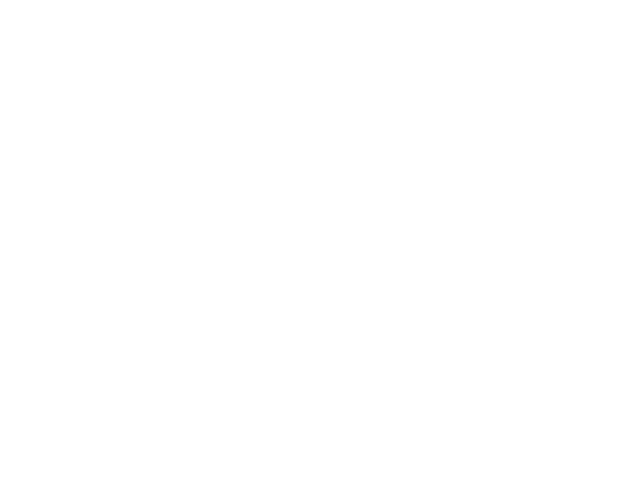

Text(0.5,0.98,'CPU Usage')

In [4]:
#!/usr/bin/env python
import psutil
import matplotlib.pyplot as plt
import numpy as np
%matplotlib notebook

fig, ax = plt.subplots()
ax.set_title('CPU Usage')
ax.set_xlabel('Percentage of Load')
ax.set_ylabel('Occurances')

x = []

for i in range(10):
    x.append(psutil.cpu_percent() + 3*i)

ax.bar(range(10), x, color = 'r')
fig.suptitle('CPU Usage', fontsize=16)



Now for our workflow on the problem at hand. A typical Data Science workflow is:
* Determine your problem statement
* Collect and clean an appropriate Data set
* Select a model appropriate for your problem and train it
* Validate your model and make sure it solves your chosen problem.

For this example problem, we have selected the below: 
* We need a model to recognize images of new clothing samples for our online store
* We have a data set of pre-tagged clothing examples
* We will build a simple Convolutional Neural Network
* Test it’s accuracy and see how well we did


In [5]:
# Make sure we're running TensorFlow 1.13
#!pip install --user tensorflow==1.13.1


First, let's import the libaries we need from Tensorflow, Keras, and Python so we can train a model. 

In [6]:
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.datasets import fashion_mnist
import numpy as np
import matplotlib.pyplot as plt
%matplotlib notebook
from tensorflow.keras.models import load_model
print(tf.VERSION)
print(tf.__file__)
print(tf.keras.__version__)

/glob/intel-python/versions/2018u2/intelpython3/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


1.13.1
/home/u25945/.local/lib/python3.6/site-packages/tensorflow/__init__.py
2.2.4-tf


In [7]:
#defining our callback to stop when we get great accuracy
class myCallback(keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('acc')>0.998):
      print("\nReached 99.8% accuracy so cancelling training!")
      self.model.stop_training = True

callbacks = myCallback()


# Collect Data

There is already a data set that is freely available to use and built into the Keras library we are using. It's known as the FashionMNIST data set. It's a collection of clothing that fits into 1 of 10 categories. Similar to the MNIST data set which consists of handritten digits (0-9), this data set is a good introduction to computer vision with Deep learning. The command below downloads and loads this dataset into memory so we can explore it.

In [8]:
#Load our Data into Two Groups, Training and Validation
(training_images, training_labels), (test_images, test_labels) = fashion_mnist.load_data()

In [9]:
# Define the text labels
fashion_mnist_labels = ["T-shirt/top",  # index 0
                        "Trouser",      # index 1
                        "Pullover",     # index 2 
                        "Dress",        # index 3 
                        "Coat",         # index 4
                        "Sandal",       # index 5
                        "Shirt",        # index 6 
                        "Sneaker",      # index 7 
                        "Bag",          # index 8 
                        "Ankle boot"]   # index 9

We can take a quick look by viewing the third image in our data set. 

<IPython.core.display.Javascript object>


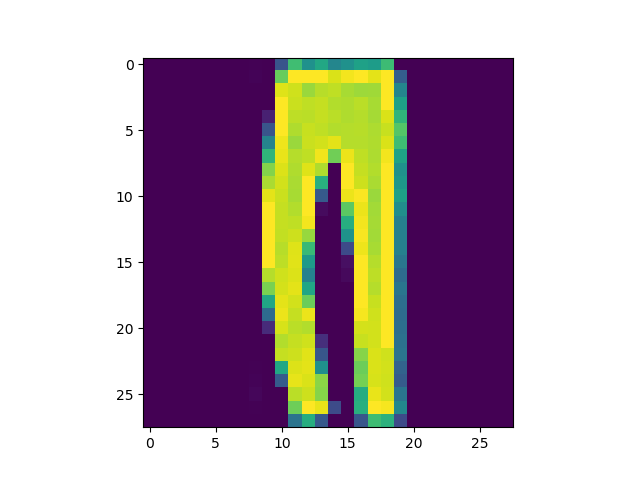

Trouser


In [10]:
#What's in our data?
plt.imshow(test_images[2])
print(fashion_mnist_labels[test_labels[2]])

We can also see what the full distribution of items are in our training set (6000 images of each class).

<IPython.core.display.Javascript object>


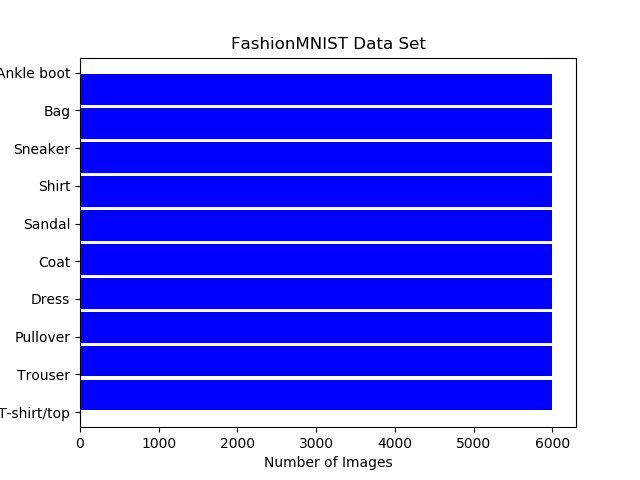

(array([6000., 6000., 6000., 6000., 6000., 6000., 6000., 6000., 6000.,
        6000.]),
 array([0. , 0.9, 1.8, 2.7, 3.6, 4.5, 5.4, 6.3, 7.2, 8.1, 9. ]),
 <a list of 10 Patch objects>)

In [25]:
fig, ax = plt.subplots()
ax.set_title('FashionMNIST Data Set')
ax.set_xlabel('Number of Images')
ax.set_ylabel('Item')
plt.yticks(np.arange(10),fashion_mnist_labels)

ax.hist(training_labels, orientation='horizontal', color = 'b', rwidth=.9)

In [6]:
#Reshape and normalize our images so that they can be fed into a DL Model
training_images=training_images.reshape(60000, 28, 28, 1)
training_images=training_images / 255.0
test_images = test_images.reshape(10000, 28, 28, 1)
test_images=test_images/255.0


# Modeling

The next step in the data science process is choosing a model. Keras makes it easy to create layers, so the below code creates a simple Convolutional Neural Network (CNN), which is great for image recognition. 

In [7]:
#Defining our Model in Keras is Easy! 
model = keras.models.Sequential([
    #1 Convolutional layer to extract data
  keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(28, 28, 1)),
    #1 Pooling Layer to compress the data
  keras.layers.MaxPooling2D(2, 2),
    #Flatten data layer to make it fit
  keras.layers.Flatten(),
    #Then 1 Dense layer that is actually running our inference
  keras.layers.Dense(128, activation='relu'),
    #And then our final layer of outputs, 1 for each of our fashion categories
  keras.layers.Dense(10, activation='softmax')
])

Instructions for updating:
Colocations handled automatically by placer.


In [8]:
#Let's look at our model summary
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 13, 13, 32)        0         
_________________________________________________________________
flatten (Flatten)            (None, 5408)              0         
_________________________________________________________________
dense (Dense)                (None, 128)               692352    
_________________________________________________________________
dense_1 (Dense)              (None, 10)                1290      
Total params: 693,962
Trainable params: 693,962
Non-trainable params: 0
_________________________________________________________________


For a sanity check, let's make sure that our model can injest the data and that we need to train it. The below code runs a random sample of our dataset through our untrained model and displays it's accuracy and then guesses. They are mostly wrong.

On the images below, red represents an incorrect guess and green is correct. The actual output is in parenthesis whereas the prediction of our model comes before.

In [9]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
# Evaluate the model on test set, even though we haven't trained it, just to see how it does
score = model.evaluate(test_images, test_labels, verbose=0)
# Print test accuracy
print('\n', 'Test accuracy:', score[1])


 Test accuracy: 0.0574


<IPython.core.display.Javascript object>


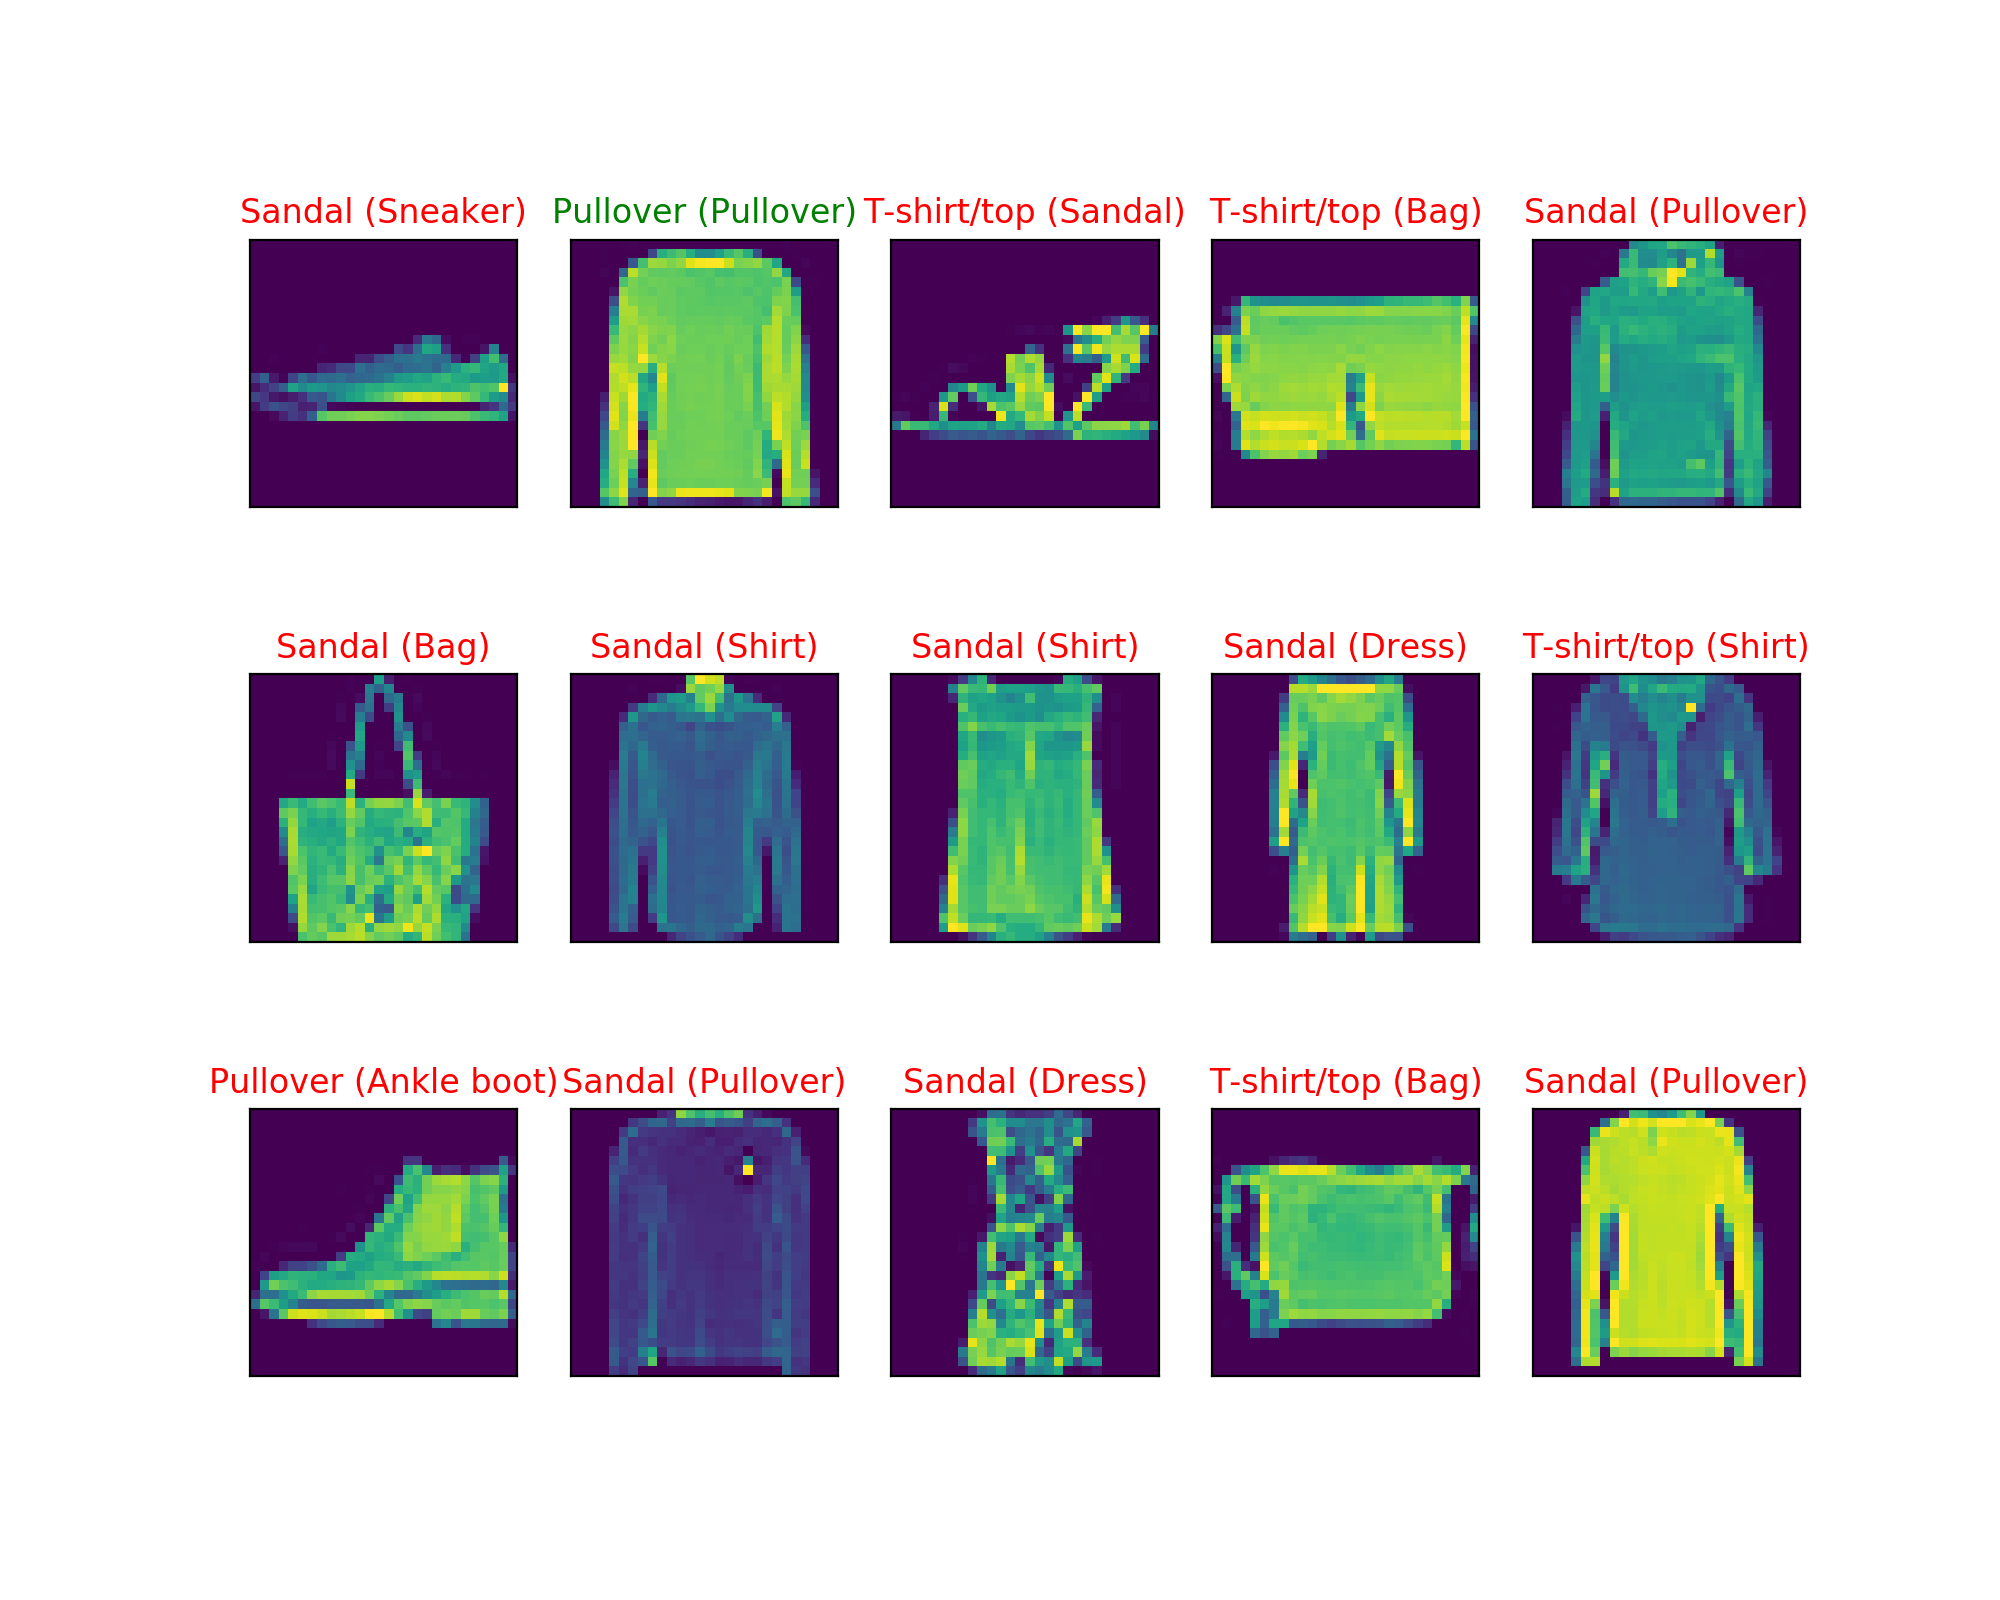

In [10]:
#Let's run our model before training and see how it does
pred_out = model.predict(test_images)
# Plot a random sample of 10 test images, their predicted labels and ground truth
figure = plt.figure(figsize=(10, 8))
for i, index in enumerate(np.random.choice(test_images.shape[0], size=15, replace=False)):
    ax = figure.add_subplot(3, 5, i + 1, xticks=[], yticks=[])
    # Display each image
    ax.imshow(np.squeeze(test_images[index]))
    predict_label = np.argmax(pred_out[index])
    true_label = test_labels[index]
    # Set the title for each image
    ax.set_title("{} ({})".format(fashion_mnist_labels[predict_label], 
                                  fashion_mnist_labels[true_label]),
                                  color=("green" if predict_label == true_label else "red"))

# Train our Model

Now, since the DevCloud is a shared resource, you have to submit jobs to a queue in order for them to get processed. We have already written the above code in a standalone python file. The code below submits this to the q. This should take roughly 4 minutes to train on 1 node.

In [ ]:
!qsub fashionMNISTjob

"qstat" checks on the status of our job in the queue. The cell below checks for us. You should see 2 jobs, 1 job is taken up by running this notebook. The other is our training job. Rerun the below cell after roughly 4 minutes to see where we are at. When it's down to just the Jupyter job, your model is trained.

In [ ]:
!qstat

Just to verify we have an output, let's see everything that is related to the job we just ran. We can also see the output of the job which shows our epochs and the final accuracy.

In [ ]:
%ls fashionMNISTjob.*

In [ ]:
%cat fashionMNISTjob.o*

# Validation of our Model

Now that we have trained our model, we want to make sure it works. Just as we did above, we are going to run a random sample of our data set through the model in order to see it's predictions. We also want to know how accurate it is over the whole data set.

NOTE: This cell won't work without a trained model stored as a file. Make sure the job above finishes before attempting to run the cells below.

In [11]:
trained_model = load_model('fashion_model.h5')
# Evaluate the model on test set again after training
score = trained_model.evaluate(test_images, test_labels, verbose=0)
# Print test accuracy
print('\n', 'Test accuracy:', score[1])


 Test accuracy: 0.9178


<IPython.core.display.Javascript object>


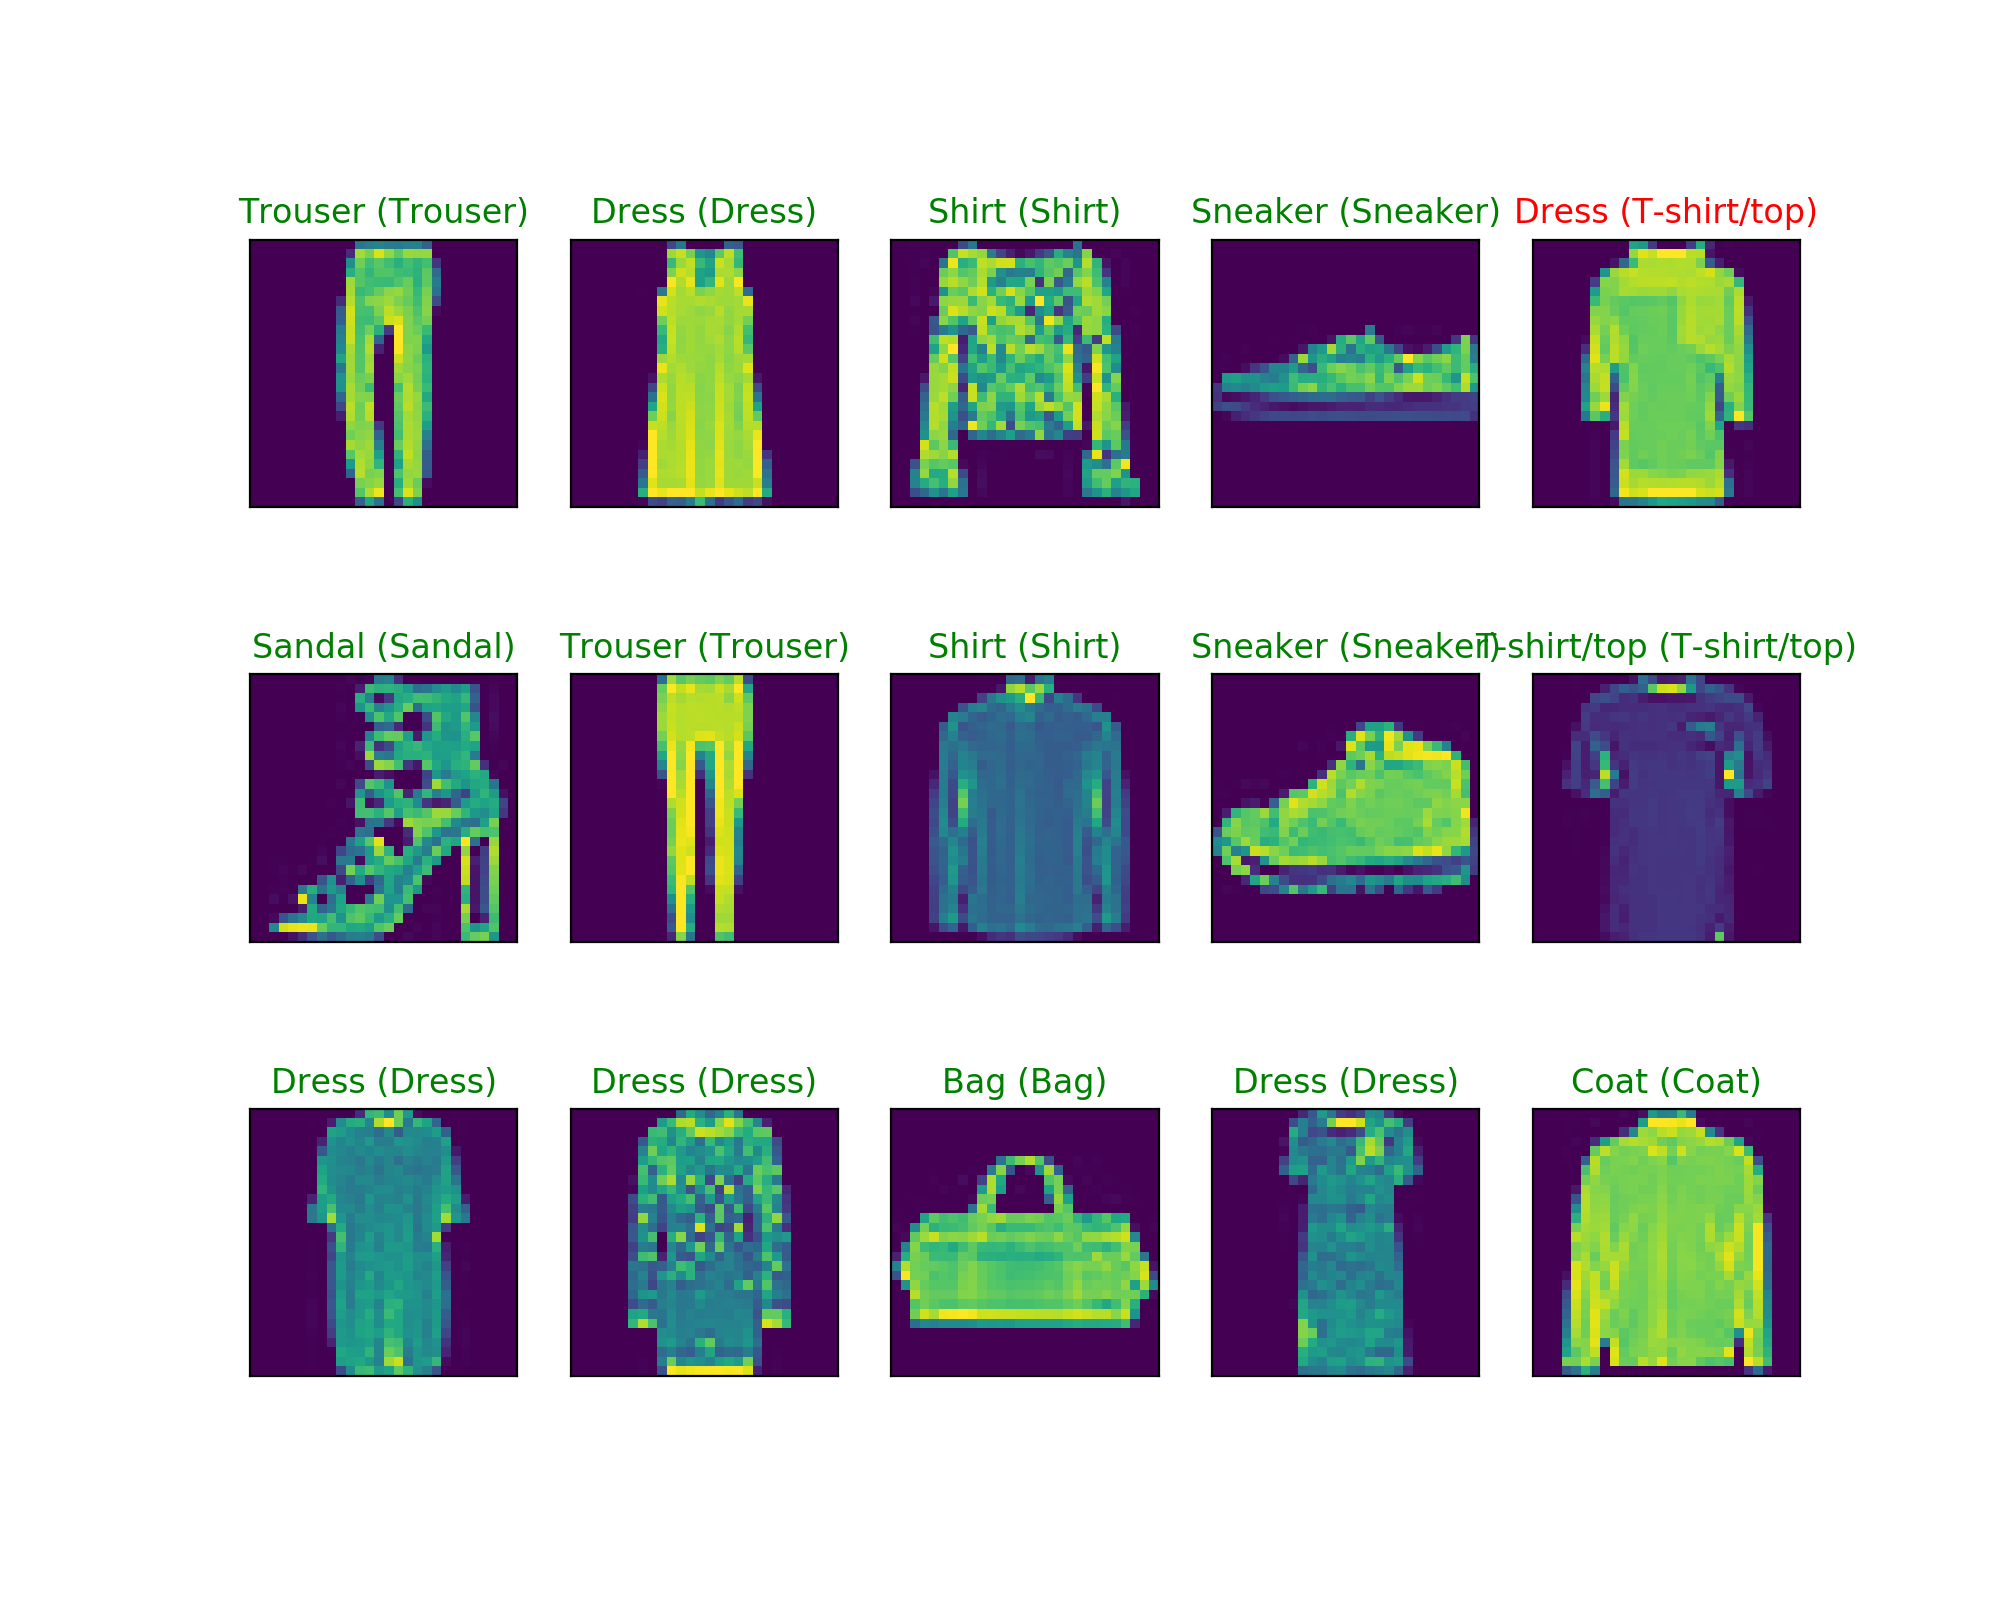

In [12]:
#Now let's see how our model does
pred_out = trained_model.predict(test_images)
# Plot a random sample of 10 test images, their predicted labels and ground truth
figure = plt.figure(figsize=(10, 8))
for i, index in enumerate(np.random.choice(test_images.shape[0], size=15, replace=False)):
    ax = figure.add_subplot(3, 5, i + 1, xticks=[], yticks=[])
    # Display each image
    ax.imshow(np.squeeze(test_images[index]))
    predict_label = np.argmax(pred_out[index])
    true_label = test_labels[index]
    # Set the title for each image
    ax.set_title("{} ({})".format(fashion_mnist_labels[predict_label], 
                                  fashion_mnist_labels[true_label]),
                                  color=("green" if predict_label == true_label else "red"))

That's it! We have defined a problem, chosen a dataset, selected a model, and subsequently trained and verified that our model works. 